# Return Period for La ReUnion Best Track Data

This notebook reviews the return period using La ReUnion Best Track data

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [3]:
import geopandas as gpd
import pandas as pd
import math
from pathlib import Path
import os
from datetime import datetime
from shapely.geometry import Point

In [4]:
AA_DATA_DIR = os.getenv("AA_DATA_DIR")
adm0_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "mdg"
    / "cod_ab"
    / "mdg_admbnda_adm0_BNGRC_OCHA_20181031.shp"
)
gdf_adm0 = gpd.read_file(adm0_path)

<Axes: >

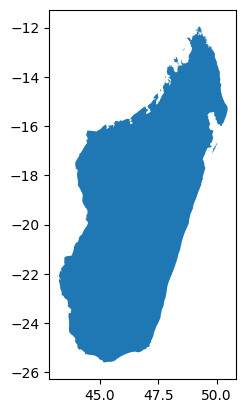

In [5]:
gdf_adm0.plot()

In [6]:
# loading all actual cyclone tracks
cyclone_tracks = pd.read_csv(
    Path(AA_DATA_DIR)
    / "private"
    / "raw"
    / "moz"
    / "rsmc"
    / "data_cyclone_SWIO_19851986_to_20222023.csv"
)

In [7]:
cyclone_tracks["Lat"] = cyclone_tracks["Lat"].apply(lambda x: -x if x > 0 else x)
cyclone_tracks_buffer = cyclone_tracks.copy()
cyclone_tracks_buffer["RMW_km"] = cyclone_tracks_buffer["RMW (mn)"] * 1.852

In [8]:
cyclone_tracks_buffer["RMW_km"] = (
    cyclone_tracks_buffer["RMW_km"].fillna(0.001).replace(0, 0.001)
)

In [9]:
cyclone_tracks["geometry"] = cyclone_tracks.apply(
    lambda row: Point(row["Lon"], row["Lat"]), axis=1
)
cyclone_tracks_gdf = gpd.GeoDataFrame(
    cyclone_tracks, geometry="geometry", crs="EPSG:4326"
)
cyclone_tracks_buffer["geometry"] = cyclone_tracks.apply(
    lambda row: Point(row["Lon"], row["Lat"]), axis=1
)
cyclone_tracks_gdf_buffer = gpd.GeoDataFrame(
    cyclone_tracks_buffer, geometry="geometry", crs="EPSG:4326"
)
cyclone_tracks_gdf_buffer["geometry"] = cyclone_tracks_gdf_buffer.geometry.buffer(
    cyclone_tracks_gdf_buffer["RMW_km"] / 110.574
)

C:\Users\pauni\AppData\Local\Temp\ipykernel_40800\3989432146.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cyclone_tracks_gdf_buffer.geometry.buffer(


In [10]:
cyclone_tracks_sel = gpd.sjoin(
    cyclone_tracks_gdf, gdf_adm0, how="inner", predicate="intersects"
)

cyclone_tracks_sel_buffer = gpd.sjoin(
    cyclone_tracks_gdf_buffer, gdf_adm0, how="inner", predicate="intersects"
)

<Axes: >

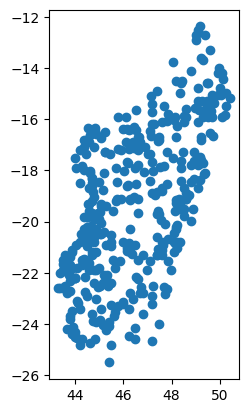

In [11]:
cyclone_tracks_sel.plot()

<Axes: >

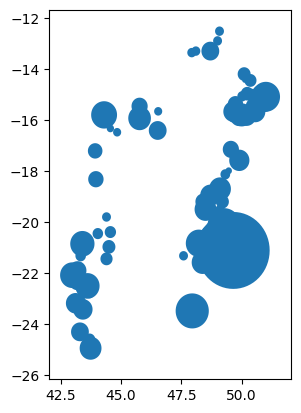

In [12]:
cyclone_tracks_sel_buffer.plot()

In [13]:
cyclone_tracks_sel["Name"].unique()

array(['ALIFREDY', 'HONORININA', 'CALIDERA', 'DOAZA', 'FILAO', 'HELY',
       'CALASANJY', 'IANA', 'ALIBERA', 'CYNTHIA', 'G19091', 'BRYNA',
       'ELIZABETHA', 'DESSILIA', 'GRACIA', 'HUTELLE', 'IONIA', 'DAISY',
       'GERALDA', 'JULITA', 'LITANNE', 'CHRISTELLE', 'BONITA', 'FABRIOLA',
       'GRETELLE', 'JOSIE', 'BELTANE', 'ASTRIDE', 'ELINE', 'GLORIA',
       'HUDAH', 'DERA', 'CYPRIEN', 'GUILLAUME', 'KESINY', 'FARI',
       'JAPHET', 'CELA', 'ELITA', 'GAFILO', 'FELAPI', '720052006',
       'BOLOETSE', 'BONDO', 'CLOVIS', 'INDLALA', 'JAYA', 'FAME', 'IVAN',
       'JOKWE', 'FANELE', 'JADE', 'FAMI', 'HUBERT', 'BINGIZA', 'CHANDA',
       'GIOVANNA', 'IRINA', 'HARUNA', 'DELIWE', '820132014', 'HELLEN',
       'CHEDZA', '1120142015', 'ENAWO', 'AVA', 'ELIAKIM', 'BELNA',
       'DIANE', 'FRANCISCO', 'CHALANE', 'ELOISE', 'IMAN', 'ANA',
       'BATSIRAI', 'DUMAKO', 'EMNATI', 'GOMBE', 'JASMINE', 'CHENESO',
       'FREDDY'], dtype=object)

In [19]:
def calculate_storm_return_period_la_reunion(df, wind_speed_kmh, start_year):

    # Conversion factor from kilometers per hour to knots
    kmh_to_knots = 1 / 1.852

    # Convert the given speed from km/h to knots
    speed_knots = wind_speed_kmh * kmh_to_knots

    # Ensure UTC is formatted as a two-digit hour
    df["UTC"] = df["UTC"].apply(lambda x: f"{int(x):02}")
    # Create a datetime column from separate date and time columns
    df["ISO_TIME"] = pd.to_datetime(
        df[["Year", "Month", "Day", "UTC"]].astype(str).agg(" ".join, axis=1)
    )

    # Extract the year from the 'ISO_TIME' column
    df["year"] = df["ISO_TIME"].dt.year

    # Filter the DataFrame for records from the start year and with wind speed above the threshold
    df_filtered = df[(df["year"] >= start_year) & (df["Max wind (kt)"] >= speed_knots)]

    # Count unique storms
    unique_storms = df_filtered["Name"].nunique()

    # Calculate the total number of years in the filtered DataFrame
    yr_len = 2023 - start_year + 1

    # Calculate the combined return period
    combined_return_period = yr_len / unique_storms

    print(
        f"The combined return period of storms over {wind_speed_kmh} km/h is 1-in-{round(combined_return_period, 1)} years."
    )

In [20]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel, wind_speed_kmh=118, start_year=1980
)

The combined return period of storms over 118 km/h is 1-in-2.6 years.


In [22]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_buffer, wind_speed_kmh=118, start_year=1980
)

The combined return period of storms over 118 km/h is 1-in-0.2 years.


In [23]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel, wind_speed_kmh=166, start_year=1980
)

The combined return period of storms over 166 km/h is 1-in-44.0 years.


In [24]:
calculate_storm_return_period_la_reunion(
    df=cyclone_tracks_sel_buffer, wind_speed_kmh=166, start_year=1980
)

The combined return period of storms over 166 km/h is 1-in-7.3 years.
